In [0]:

import numpy as np
import tensorflow as tf
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from IPython import display
import sys
from matplotlib import pyplot as plt

In [0]:
class Conv1d_Model(object):
    """
      Define conv1d model for time series analysis of gas mixtures 
      hidden_layers_numeber : layers number       
      kernel_per_size : kernel size of each layers, list [layers_number,]
      filter_per_size : filter size of each layers, list [layers_number,]
      split_layer : the layer we split the shared layer into two layers
      split_regularizer : the layer we switch a different regularizer
      regularizers : two different regularizers
      
    """
    def __init__(self,hidden_layers_number,kernel_per_size,
                 filters_per_size,split_layer,split_regularizer,regularizers):
        
        self._inputs = tf.placeholder(tf.float32,
                                      shape=[None, None, 16],
                                      name='inputs')
        
        self.hidden_layers_number = hidden_layers_number
        self.kernel_per_size = kernel_per_size
        self.filters_per_size = filters_per_size
        self.split_layer = split_layer
        self.regularizers = []
        for i in range(hidden_layers_number):
            if (split_regularizer>i+1):
                self.regularizers.append(regularizers[0])
            else:
                self.regularizers.append(regularizers[1])
        
        
    def _Conv1d(self):
        
        """
           The first parts share the same features, the second parts learn separate features. 
           
        """
        Input_1 = self._inputs
        for i in range(hidden_layers_number):
            if self.split_layer>i+1:
                paddings = tf.constant([[0, 0], [self.kernel_per_size[i]-1, 0],[0,0]])
                Padded_input = tf.pad(Input_1,paddings,"CONSTANT")
                Output = tf.layers.Conv1D(filters=self.filters_per_size[i],kernel_size=self.kernel_per_size[i],
                                         activation=None,padding='valid',kernel_regularizer=self.regularizers[i])(Padded_input)
                Output = tf.nn.selu(Output)
                Input_1 = Output
                Input_2 = Output
            else:
                paddings = tf.constant([[0, 0], [self.kernel_per_size[i]-1, 0],[0,0]])
                Padded_input_1 = tf.pad(Input_1,paddings,"CONSTANT")
                Padded_input_2 = tf.pad(Input_2,paddings,"CONSTANT")
                if i<hidden_layers_number-1:
                    Output_1 = tf.layers.Conv1D(filters=self.filters_per_size[i],kernel_size=self.kernel_per_size[i],
                                         activation=None,padding='valid',kernel_regularizer=self.regularizers[i])(Padded_input_1)
                    Output_2 = tf.layers.Conv1D(filters=self.filters_per_size[i],kernel_size=self.kernel_per_size[i],                                                
                                         activation=None,padding='valid',kernel_regularizer=self.regularizers[i])(Padded_input_2)
                else:
                    Output_1 = tf.layers.Conv1D(filters=self.filters_per_size[i],kernel_size=self.kernel_per_size[i],
                                         activation=None,padding='valid')(Padded_input_1)
                    Output_2 = tf.layers.Conv1D(filters=self.filters_per_size[i],kernel_size=self.kernel_per_size[i],                                                
                                         activation=None,padding='valid')(Padded_input_2)
                    
                if i< hidden_layers_number-1:
                    Output_1 = tf.nn.selu(Output_1)
                    Output_2 = tf.nn.selu(Output_2)                                    
                Input_1 = Output_1
                Input_2 = Output_2
        output = tf.concat([Output_1,Output_2],2)
        
        return output                                                                                                                

In [0]:
# wingloss function, the gradient would not vanish around zero.
def wingloss(v):
    w, epilson = 3, 0.01
    x = tf.abs(v)
    x = tf.keras.backend.switch(x<w , w* tf.log(1+ x/epilson) , x- (w-w*tf.log(1+w/epilson) ) )
    return x

In [0]:
target_size = 2 

Total_epoch=6000
Batch =128

In [0]:
# Define loss
"""
hidden_layers_number,kernel_per_size,
filters_per_size,split_layer,split_regularizer,regularizers
"""

y = tf.placeholder(tf.float32, shape=[None, None, target_size],name='gas_concentration')

# Hyparameters
hidden_layers_number = 7
kernel_per_size = [3,3,5,7,9,7,9] 

filter_per_size = [70,50,50,40,40,30,1]
split_layer = 3
split_regularizer = 4
regularizers=[tf.contrib.layers.l2_regularizer(scale=0.0),tf.contrib.layers.l2_regularizer(scale=0.0002)]


# Initilize the class
conv1d = Conv1d_Model(hidden_layers_number,kernel_per_size,
                      filter_per_size,split_layer,split_regularizer,regularizers)
outputs = conv1d._Conv1d()
Loss_raw = wingloss(outputs-y)
Loss_filtered = Loss_raw[:,30:,:]
Loss = tf.reduce_mean(Loss_filtered) +tf.losses.get_regularization_loss()
Loss_validation = tf.reduce_mean(Loss_filtered)


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:Scale of 0 disables regularizer.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
# Define optimizer
trainables = tf.trainable_variables() 
grads = tf.gradients(Loss, trainables[-16:]) # Freeze low layers for fine-tuning
grads, _ = tf.clip_by_global_norm(grads, clip_norm=1.)
grad_var_pairs = zip(grads, trainables[-16:])
global_step = tf.Variable(0, trainable=False)
starter_learning_rate = 0.003
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
                                           1000, 0.85, staircase=True)
optimizer = tf.train.AdamOptimizer(learning_rate)
train_step = optimizer.apply_gradients(grad_var_pairs,global_step = global_step)

In [0]:
#Data preparation
ratio = 0.7
X_data=np.load("./sensory_outs_16.npy")
y_data=np.load("./odors_16.npy")

y_data[:,0]=y_data[:,0]/25.
X_data_train = X_data[0:int(X_data.shape[0]*ratio),:]
y_data_train = y_data[0:int(X_data.shape[0]*ratio),:]

X_valid  = X_data[int(X_data.shape[0]*ratio):int(X_data.shape[0]*(ratio+0.15)),:]
y_valid = y_data[int(X_data.shape[0]*ratio):int(X_data.shape[0]*(ratio+0.15)),:]

X_test = X_data[int(X_data.shape[0]*(ratio+0.15)):,:]
y_test = y_data[int(X_data.shape[0]*(ratio+0.15)):,:]

scaler = StandardScaler().fit(X_data_train)
X_data_train = scaler.transform(X_data_train)
X_data_test = scaler.transform(X_test)
X_data_valid = scaler.transform(X_valid)

X_small=X_data_valid
y_small=y_valid
X_data_2 = np.reshape(X_small,(1,X_small.shape[0],X_small.shape[1]))

X_data_valid=np.reshape(X_data_valid,(1,X_data_valid.shape[0],X_data_valid.shape[1]))
y_valid = np.reshape(y_valid,(1,y_valid.shape[0],y_valid.shape[1]))

X_data_test=np.reshape(X_data_test,(1,X_data_test.shape[0],X_data_test.shape[1]))
X_data_train_final = np.reshape(X_data_train,((1,X_data_train.shape[0],X_data_train.shape[1])))

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7

0   Loss_train= 19.403356234232586   Validation_loss= 18.527561


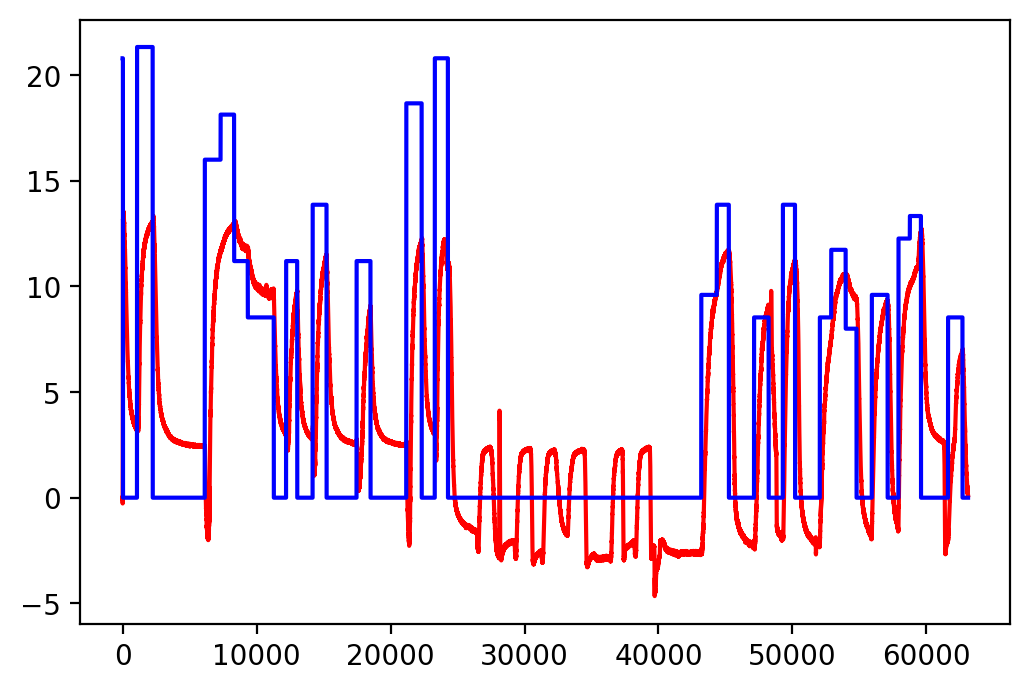

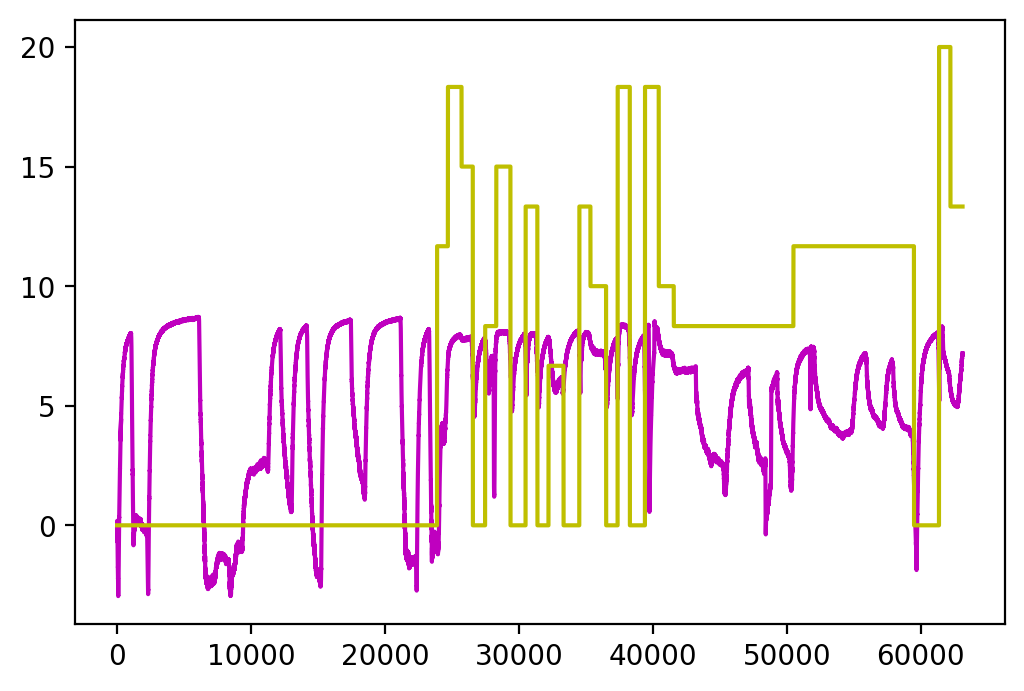

1   Loss_train= 17.318000475565594   Validation_loss= 0.0
2   Loss_train= 17.970141251881916   Validation_loss= 0.0
3   Loss_train= 17.834827264149983   Validation_loss= 0.0
4   Loss_train= 15.676045576731363   Validation_loss= 0.0
Save new weights!
5   Loss_train= 15.071823596954346   Validation_loss= 14.413206
6   Loss_train= 14.764558633168539   Validation_loss= 0.0
7   Loss_train= 13.787701765696207   Validation_loss= 0.0
8   Loss_train= 14.034539063771566   Validation_loss= 0.0
9   Loss_train= 13.195955594380697   Validation_loss= 0.0
Save new weights!
10   Loss_train= 13.767499287923178   Validation_loss= 13.2332115
11   Loss_train= 14.543782552083334   Validation_loss= 0.0
12   Loss_train= 14.237163861592611   Validation_loss= 0.0
13   Loss_train= 13.666463851928711   Validation_loss= 0.0
14   Loss_train= 13.719669183095297   Validation_loss= 0.0
15   Loss_train= 13.6302539507548   Validation_loss= 13.626164
16   Loss_train= 13.062163352966309   Validation_loss= 0.0
17   Loss_tr

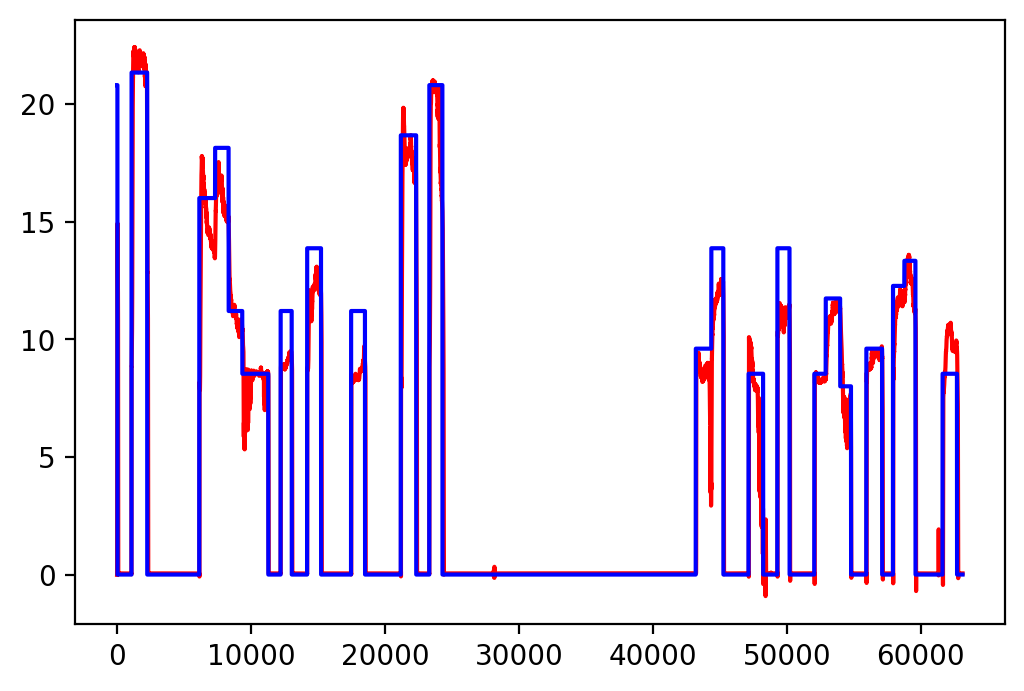

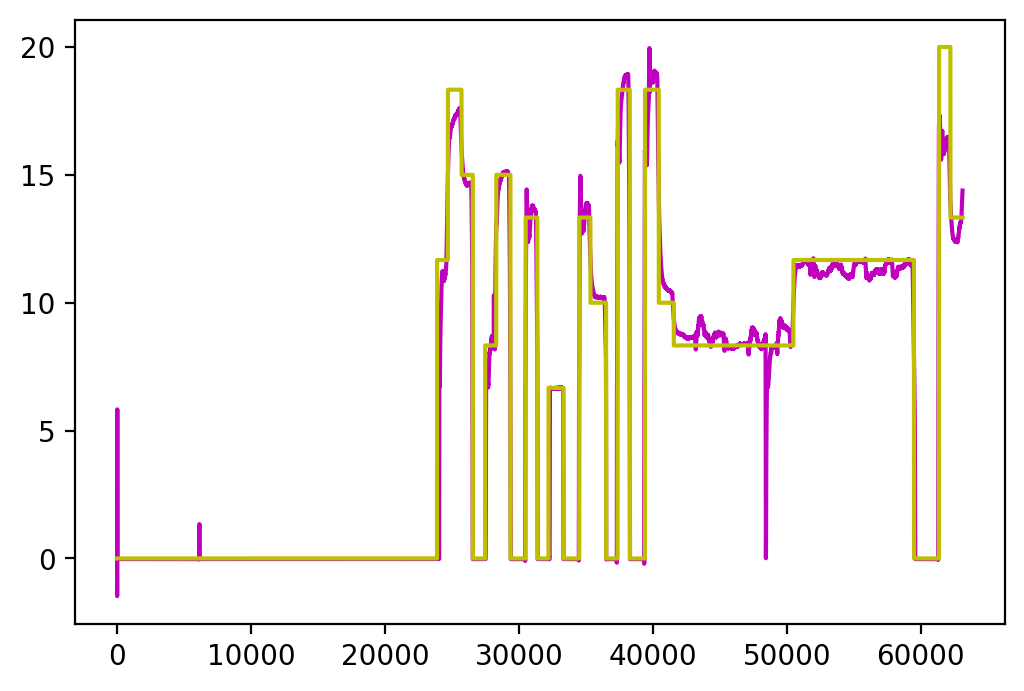

2001   Loss_train= 6.381473255157471   Validation_loss= 0.0
2002   Loss_train= 6.664148998260498   Validation_loss= 0.0
2003   Loss_train= 7.055967712402344   Validation_loss= 0.0
2004   Loss_train= 7.135795593261719   Validation_loss= 0.0
2005   Loss_train= 5.934364891052246   Validation_loss= 6.5079823
2006   Loss_train= 6.104684162139892   Validation_loss= 0.0
2007   Loss_train= 6.210944652557373   Validation_loss= 0.0
2008   Loss_train= 6.879084777832031   Validation_loss= 0.0
2009   Loss_train= 8.262617206573486   Validation_loss= 0.0
2010   Loss_train= 7.363064193725586   Validation_loss= 8.833733
2011   Loss_train= 8.324527740478516   Validation_loss= 0.0
2012   Loss_train= 8.400566482543946   Validation_loss= 0.0
2013   Loss_train= 8.493305683135986   Validation_loss= 0.0
2014   Loss_train= 7.141928768157959   Validation_loss= 0.0
2015   Loss_train= 7.981452560424804   Validation_loss= 8.691516
2016   Loss_train= 8.754213237762452   Validation_loss= 0.0
2017   Loss_train= 8.707

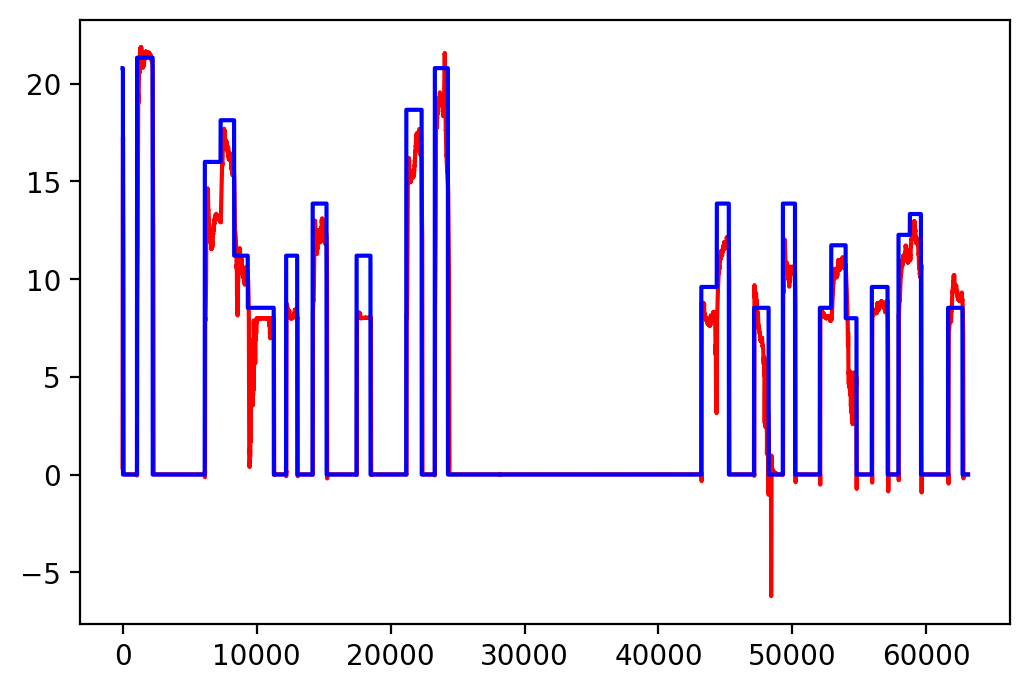

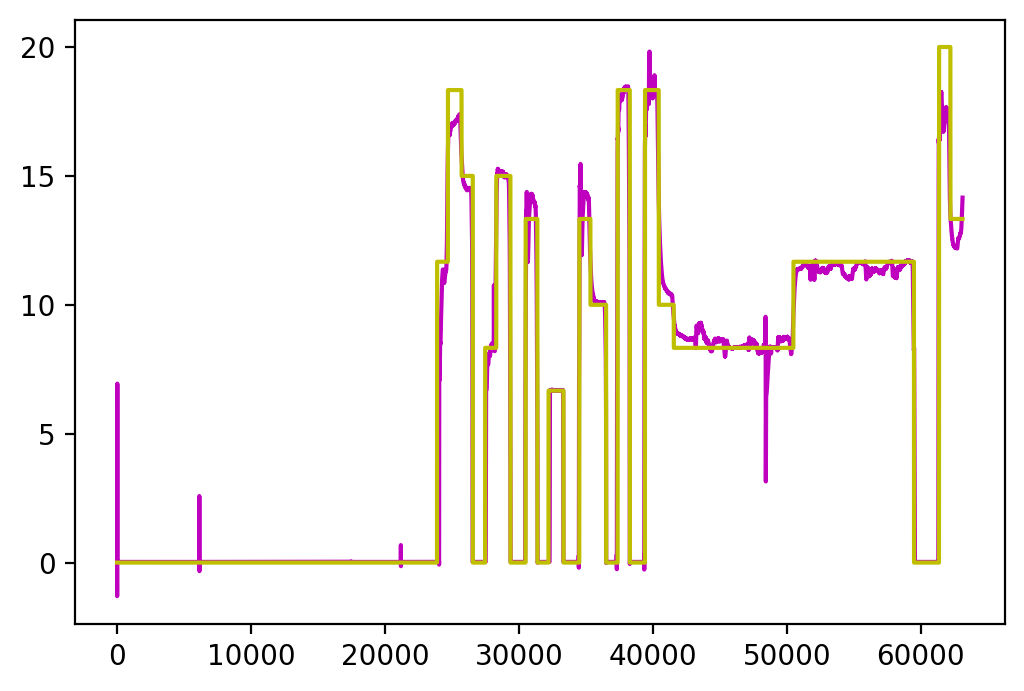

4001   Loss_train= 5.185072183609009   Validation_loss= 0.0
4002   Loss_train= 5.078291535377502   Validation_loss= 0.0
4003   Loss_train= 5.01164984703064   Validation_loss= 0.0
4004   Loss_train= 4.720635970433553   Validation_loss= 0.0
4005   Loss_train= 4.926924705505371   Validation_loss= 6.3254943
4006   Loss_train= 4.8272420565287275   Validation_loss= 0.0
4007   Loss_train= 4.498204867045085   Validation_loss= 0.0
4008   Loss_train= 4.496930837631226   Validation_loss= 0.0
4009   Loss_train= 4.764177123705546   Validation_loss= 0.0
4010   Loss_train= 4.9970479011535645   Validation_loss= 6.2635064
4011   Loss_train= 4.82157317797343   Validation_loss= 0.0
4012   Loss_train= 4.777804454167684   Validation_loss= 0.0
4013   Loss_train= 4.769477764765422   Validation_loss= 0.0
4014   Loss_train= 4.798978805541992   Validation_loss= 0.0
4015   Loss_train= 4.698636690775554   Validation_loss= 6.082295
4016   Loss_train= 4.779119332631429   Validation_loss= 0.0
4017   Loss_train= 4.33

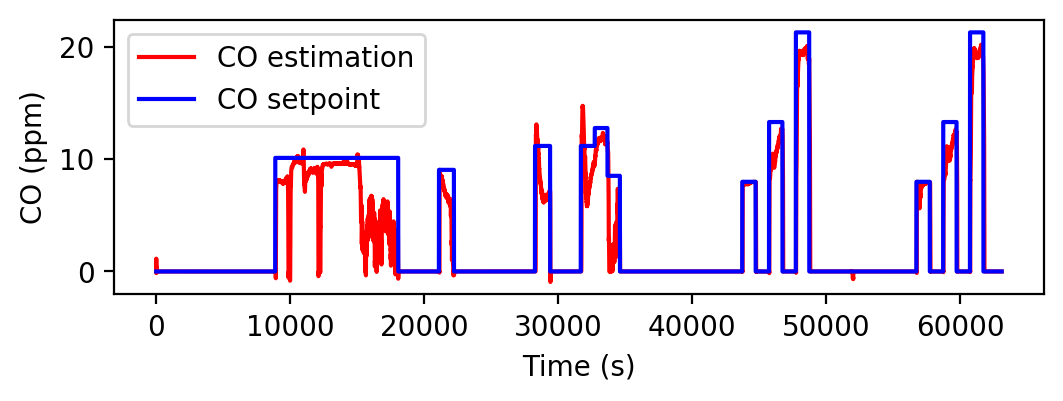

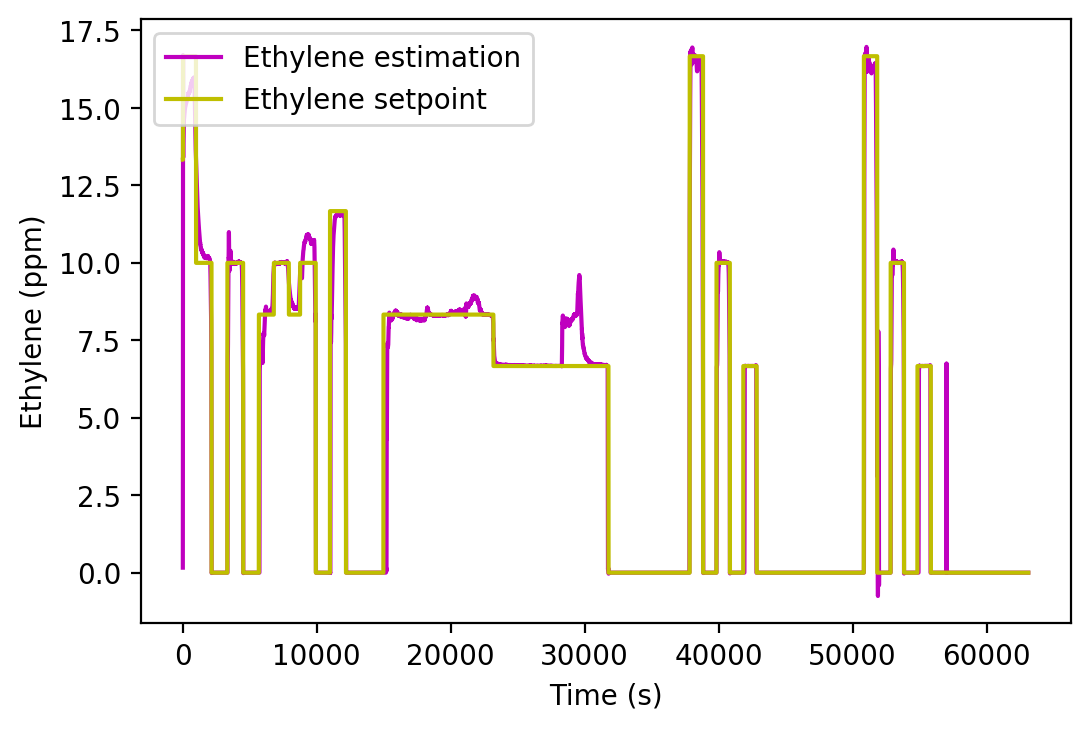

/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


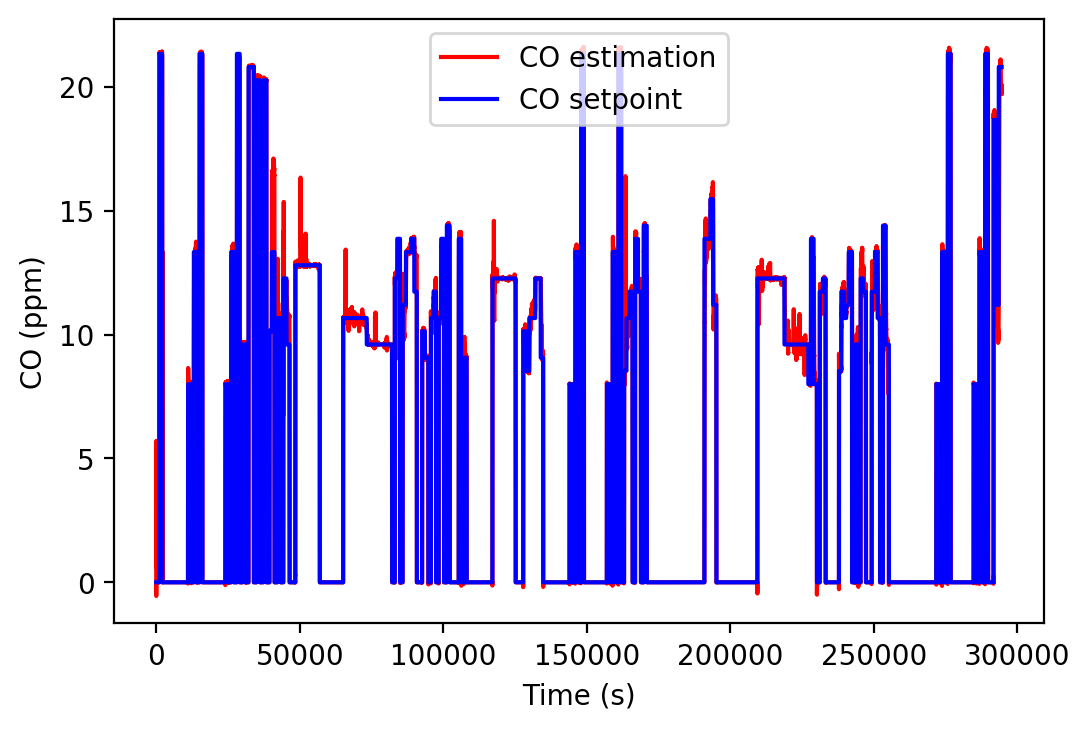

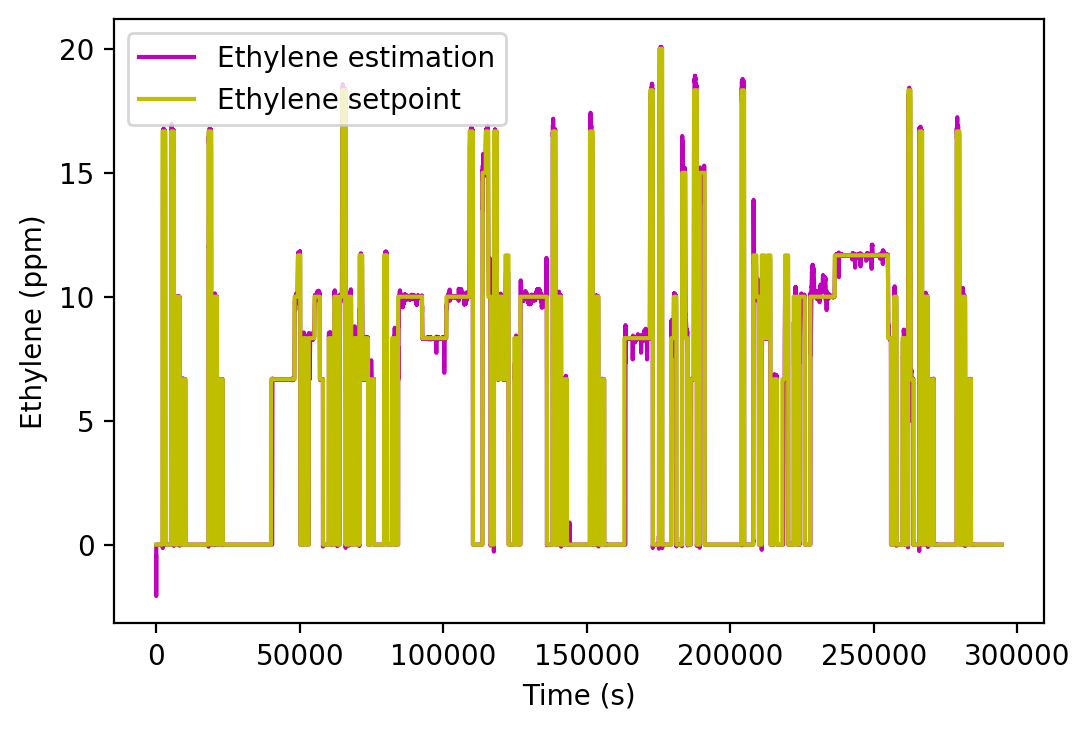

In [0]:
"""
Training session and save the weights.
"""

with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
    
    variables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
    sess.run(tf.global_variables_initializer())
    new_savers = tf.train.Saver(variables[:8])
    new_saver = tf.train.Saver(variables)
    recover_save_path = '/conv1d_selu_2_fine_tuning.ckpt'
    save_path = "./"

    sess.run(tf.variables_initializer(variables[-16:]))
    Best_loss = sess.run(Loss_validation,feed_dict={conv1d._inputs:X_data_valid,y:y_valid})
    for epoch in range(Total_epoch):
        start = 0
        end = Batch
        
        Loss_value = 0.
        Validation_loss_value=0.
        
        if epoch %50==0:
            Inter = np.random.randint(400,high=500)
            Time_interval = np.random.randint(600,high=800)
            X_train = np.random.randn( (X_data_train.shape[0]-Time_interval)//Inter+1,
                      Time_interval,X_data_train.shape[1])
            
            y_train = np.zeros(( (X_data_train.shape[0]-Time_interval)//Inter+1,
                      Time_interval,y_data_train.shape[1]))

            for i in range((X_data_train.shape[0]-Time_interval)//Inter+1):
                X_train[i,:,:] = X_train[i,:,:]*np.random.randn(1)*0.2+ X_data_train[i*Inter:i*Inter+Time_interval,:]
                y_train[i,:,:] =  y_data_train[i*Inter:i*Inter+Time_interval,:]

            Total_chunk = (X_data_train.shape[0]-Time_interval)//Inter+1    
        
        for i in range(int(Total_chunk/Batch)+1):
            if end>Total_chunk:
                X = X_train[start:]
                Y = y_train[start:]
            else:
                X = X_train[start:end]
                Y = y_train[start:end]
                start = end
                end = start+Batch
            _,Loss_local=sess.run([train_step,Loss],feed_dict={conv1d._inputs:X,y:Y})
            Loss_value +=Loss_local
        if (epoch % 5==0):
            Validation_loss_value=sess.run(Loss_validation,feed_dict={conv1d._inputs:X_data_valid,y:y_valid})
            if Validation_loss_value<Best_loss:
                new_saver.save(sess,save_path)
                print("Save new weights!")
                Best_loss = Validation_loss_value
                                            
        Loss_value = Loss_value/(int(Total_chunk/Batch)+1.)                 
        print(epoch," ","Loss_train=",Loss_value," ","Validation_loss=",Validation_loss_value)
        
        if (epoch % 2000==0):
            Prediction=sess.run(outputs,feed_dict={conv1d._inputs:X_data_2})
            Prediction = np.reshape(Prediction,(Prediction.shape[1],Prediction.shape[2]))
            nx = 2
            ny = 1
            
            plt.figure(dpi=200)
            plt.plot(Prediction[:,0], 'r',label='CO estimation')
            plt.plot(y_small[:,0], 'b',label='CO setpoint') 
  
            plt.show()
            
            plt.figure(dpi=200)
            plt.plot(Prediction[:,1], 'm',label='Ethylene estimation')
            plt.plot(y_small[:,1], 'y',label='Ethylene setpoint')
          
            plt.show()
    
    
    new_saver.restore(sess,save_path)
    
    Prediction=sess.run(outputs,feed_dict={conv1d._inputs:X_data_test})
    Prediction = np.reshape(Prediction,(Prediction.shape[1],Prediction.shape[2]))
    nx = 2
    ny = 1
    plt.figure(dpi=200)      
    plt.subplot(nx, ny, 1)
    plt.plot(Prediction[:,0], 'r',label='CO estimation')
    plt.plot(y_test[:,0], 'b',label='CO setpoint')
    plt.xlabel('Time (s)')
    plt.ylabel('CO (ppm)')
    plt.legend(['CO estimation', 'CO setpoint'])


    plt.show() 
    
    plt.figure(dpi=200)    
    plt.plot(Prediction[:,1], 'm',label='Ethylene estimation')
    plt.plot(y_test[:,1], 'y',label='Ethylene setpoint')
    plt.xlabel('Time (s)')
    plt.ylabel('Ethylene (ppm)')
    plt.legend(['Ethylene estimation', 'Ethylene setpoint'])

    plt.show() 
    
    train_output=sess.run(outputs,feed_dict={conv1d._inputs:X_data_train_final})
    train_output = np.reshape(train_output,(train_output.shape[1],train_output.shape[2]))
    nx = 2
    ny = 1
    plt.figure(dpi=200)
    plt.plot(train_output[:,0], 'r',label='CO estimation')
    plt.plot(y_data_train[:,0], 'b',label='CO setpoint')
    plt.xlabel('Time (s)')
    plt.ylabel('CO (ppm)')
    plt.legend(['CO estimation', 'CO setpoint'])

    plt.show()
    plt.figure(dpi=200)
    plt.plot(train_output[:,1], 'm',label='Ethylene estimation')
    plt.plot(y_data_train[:,1], 'y',label='Ethylene setpoint')
    plt.xlabel('Time (s)')
    plt.ylabel('Ethylene (ppm)')
    plt.legend(['Ethylene estimation', 'Ethylene setpoint'])

    plt.show() 
    

In [0]:
# compute RMSE
CO_pred = Prediction[:, 0]
CO_test = y_test[:, 0]
CO_rms = np.sqrt(np.average(np.square(CO_pred - CO_test)))
print('The root mean square for CO gas is', CO_rms)

ethy_pred = Prediction[:, 1]
ethy_test = y_test[:, 1]
ethy_rms = np.sqrt(np.average(np.square(ethy_pred - ethy_test)))
print('The root mean square for ethylene gas is', ethy_rms)

The root mean square for CO gas is 2.4924215724075798
The root mean square for ethylene gas is 1.123504177564429


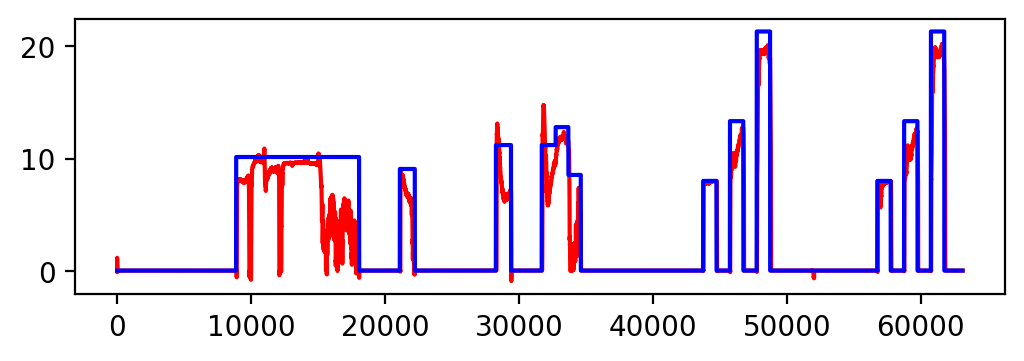

In [0]:
plt.figure(dpi=200)      
plt.subplot(nx, ny, 1)
plt.plot(Prediction[:,0], 'r',label='CO estimation')
plt.plot(y_test[:,0], 'b',label='CO setpoint')
plt.savefig(fname="CO_6k_prediction1",format="png")

plt.show() 

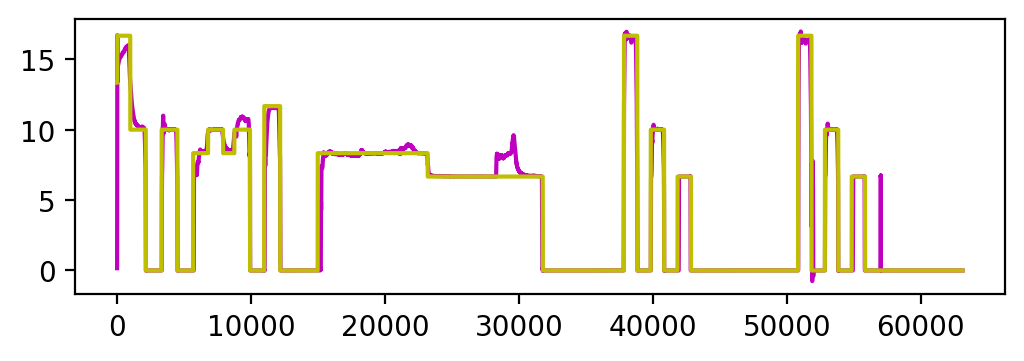

In [0]:
plt.figure(dpi=200)      
plt.subplot(nx, ny, 1)
plt.plot(Prediction[:,1], 'm',label='Ethylene estimation')
plt.plot(y_test[:,1], 'y',label='Ethylene setpoint')

plt.savefig(fname="CO_6k_prediction1",format="png")
plt.show()